In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import tqdm
import torch
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import seaborn

from sklearn.decomposition import PCA

from torch.utils.data import DataLoader

import vari
import vari.datasets
import vari.models
import vari.inference

from vari.layers import GaussianLayer, BernoulliLayer
from vari.utilities import compute_dataset_elbo, remove_outliers, get_device

from sklearn.datasets import make_circles

In [3]:
experiments_dir = '/nas/experiments/sacred/models/'
data_root = '/home/jdh/repos/vari/torch_data'
output_dir = f'{os.getcwd()}/plots'
plot_ext = '.svg'
mpl.style.use('default')
device = get_device()
print(device)

cuda:0


In [4]:
def get_constant_colormap(rgb_color):
    # Colormap that is constant at the given rgb_color.
    r, g, b = rgb_color
    cdict = {'red': [(0, r, r), (1, r, r)], 
             'green': [(0, g, g), (1, g, g)],
             'blue': [(0, b, b), (1, b, b)]}
    return mcolors.LinearSegmentedColormap('CustomMap', cdict)

## Select models and data

In [5]:
run_ids_svhn = {
    '[64]': 7854,
    '[64,32]': 7856,
}

run_ids_cifar10 = {
    '[64,32,16]': 7848,
}

## Get data

In [6]:
svhn_train = vari.datasets.SVHNContinuous(split='train', preprocess='static', exclude_labels=[], root=data_root)
svhn_test1 = vari.datasets.SVHNContinuous(split='test', preprocess='static', exclude_labels=[], root=data_root)
cifar10_train = vari.datasets.CIFAR10Continuous(split='train', preprocess='static', exclude_labels=[], root=data_root)
cifar10_test1 = vari.datasets.CIFAR10Continuous(split='test', preprocess='static', exclude_labels=[], root=data_root)

Using downloaded and verified file: /home/jdh/repos/vari/torch_data/train_32x32.mat
Using downloaded and verified file: /home/jdh/repos/vari/torch_data/test_32x32.mat
Files already downloaded and verified
Files already downloaded and verified


### Visualize dataset

In [7]:
def get_image_matrix(images):
    """Converts a list of images to a single image matrix by concatenation"""
    rows = int(np.sqrt(len(images)))
    cols = rows
    image_rows = []
    for i in range(rows):
        image_rows += [np.concatenate(images[i*cols:(i+1)*cols], axis=1)]
    image_matrix = np.concatenate(image_rows, axis=0)
    return image_matrix


def plot_image_matrix(images, ax):
    image_matrix = get_image_matrix(images)
    ax.imshow(image_matrix, cmap='binary_r')
    ax.axis('off')

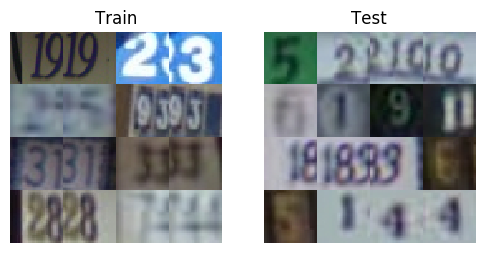

In [8]:
start_idx = 0
n_images = 4 * 4
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 12))
plot_image_matrix([x for x in svhn_train[start_idx: start_idx + n_images][0]], ax1)
plot_image_matrix([x for x in svhn_test1[start_idx: start_idx + n_images][0]], ax2)
ax1.set_title('Train')
ax2.set_title('Test');
fig.savefig(output_dir + f'/Dataset_SVHN' + plot_ext, bbox_inches='tight')

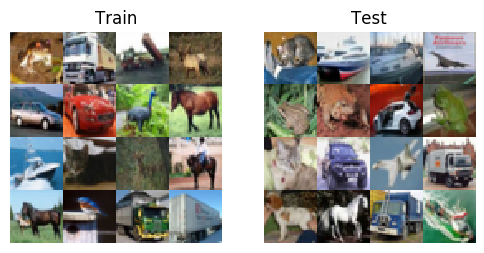

In [9]:
start_idx = 0
n_images = 4 * 4
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 12))
plot_image_matrix([x for x in cifar10_train[start_idx: start_idx + n_images][0]], ax1)
plot_image_matrix([x for x in cifar10_test1[start_idx: start_idx + n_images][0]], ax2)
ax1.set_title('Train')
ax2.set_title('Test');
fig.savefig(output_dir + f'/Dataset_CIFAR10' + plot_ext, bbox_inches='tight')

### Log Bernoulli distance between datasets

In [10]:
# Mean pixel activation
svhn_train.examples.mean(), cifar10_train.examples.mean()

(0.4516082, 0.4734668)

In [11]:
svhn_train.examples.shape

(73257, 32, 32, 3)

In [12]:
# Average number of pixels activated above 0.5
(svhn_train.examples>0.5).sum(axis=(-3,-2,-1)).mean(), \
(cifar10_train.examples>0.5).sum(axis=(-3,-2,-1)).mean()

(1174.471040310141, 1354.73636)

In [13]:
def log_bernoulli(x, p, eps=1e-8):
    return np.log(p + eps) * x + np.log(1 - p + eps) * (1 - x)

In [14]:
def nearest_neighbour_distance_bernoulli(x, p, ignore_diag):
    x = x[np.newaxis, ...]
    p = p[:, np.newaxis, ...]
    d = np.sum(log_bernoulli(x, p), axis=-1)
    if ignore_diag:
        np.fill_diagonal(d, val=np.nan)
    return np.nanmax(d, axis=-1)

In [15]:
n_samples = 200
train = svhn_train.examples[:n_samples].reshape(n_samples, -1)
test1 = cifar10_train.examples[:n_samples].reshape(n_samples, -1)
nnd_train_svhn = nearest_neighbour_distance_bernoulli(x=train, p=train, ignore_diag=True)
nnd_test1_svhn = nearest_neighbour_distance_bernoulli(x=test1, p=train, ignore_diag=False)

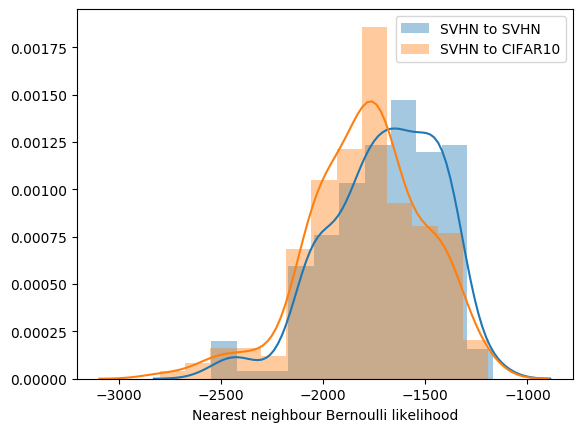

In [16]:
fig, ax = plt.subplots(1, 1)
seaborn.distplot(nnd_train_svhn, ax=ax, label='SVHN to SVHN')
seaborn.distplot(nnd_test1_svhn, ax=ax, label='SVHN to CIFAR10')
ax.set_xlabel('Nearest neighbour Bernoulli likelihood')
ax.legend()
fig.savefig(output_dir + '/DataDistance_SVHN-CIFAR10' + plot_ext, bbox_inches='tight')

In [17]:
n_samples = 200
train = cifar10_train.examples[:n_samples].reshape(n_samples, -1)
test1 = svhn_train.examples[:n_samples].reshape(n_samples, -1)
nnd_train_fashion = nearest_neighbour_distance_bernoulli(x=train, p=train, ignore_diag=True)
nnd_test1_fashion = nearest_neighbour_distance_bernoulli(x=test1, p=train, ignore_diag=False)

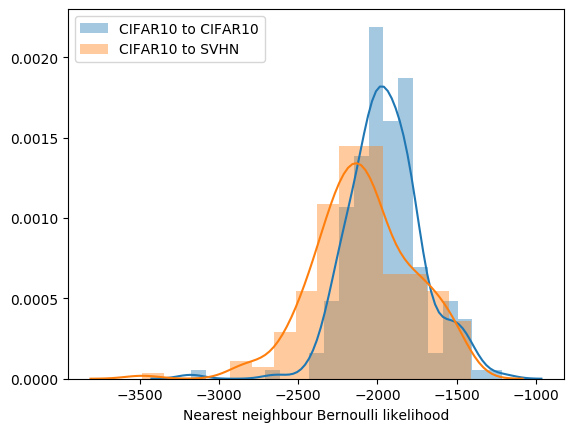

In [18]:
fig, ax = plt.subplots(1, 1)
seaborn.distplot(nnd_train_fashion, ax=ax, label='CIFAR10 to CIFAR10')
seaborn.distplot(nnd_test1_fashion, ax=ax, label='CIFAR10 to SVHN')
ax.set_xlabel('Nearest neighbour Bernoulli likelihood')
ax.legend()
fig.savefig(output_dir + '/DataDistance_CIFAR10-SVHN' + plot_ext, bbox_inches='tight')

In the above we compute the summed Bernoulli likelihood of image $I$ from CIFAR10 when the pixels of image $J$ from SVHN is used as the true probabilities for all $I$ and $J$ (really a subsample). We choose the largest of these likelihoods for each of the $J$ images and plot the distribution. We also compute this for SVHN under SVHN. Finally, we repeat this for SVHN VS CIFAR10.

We see that the distance to SVHN under CIFAR10 pixel probabilities is smaller than the difference to CIFAR10 under SVHN pixel probabilities. 

That is, SVHN is "contained within" CIFAR10. This is to be understood as SVHN activating fewer pixels and activating them less on average than CIFAR10 does.

Nalisnick claims to be able to detect CIFAR10 as OOD when training on SVHN. Also, SVHN has higher likelihoods than CIFAR10 when training on CIFAR10. This is the same assymmetry as observed in the plots above.

However, from the plots above it is clear that SVHN is not "enough within" CIFAR10 to cause SVHN to be more likely than CIFAR10 itself when evaluated under CIFAR10 pixel probabilities. This serves to show that the only way to ascribe SVHN higher likelihood than CIFAR10 when training on CIFAR10 is due to poor modelling.

### Euclidean distance between datasets

In [21]:
def nearest_neighbour_distance(xy1, xy2, ignore_diag=False):
    """Nearest neighbour distance from xy1 to xy2.
    
    If xy1 == xy2 then the distance matrix is symmetric. Otherwise it is not.
    The number of examples in of xy1 and xy2 may differ.
    
    Args:
        xy1 (np.ndarray): Shape [Examples1, Dimensionality]
        xy2 (np.ndarray): Shape [Examples2, Dimensionality]
    """
    # Euclidean distance matrix (broadcasting along newaxis)
    d = np.sqrt(np.sum((xy1[:, np.newaxis, :] - xy2[np.newaxis, :, :]) ** 2, axis=-1))
    if ignore_diag:
        np.fill_diagonal(d, val=np.nan)
    return np.nanmin(d, axis=-1)  # Minimum ignoring NaNs

In [38]:
n_samples = 300
train = svhn_train.examples[:n_samples].reshape(n_samples, -1)
test1 = cifar10_train.examples[:n_samples].reshape(n_samples, -1)
nnd_train_svhn = nearest_neighbour_distance(train, train, ignore_diag=True)
nnd_test1_svhn = nearest_neighbour_distance(test1, train, ignore_diag=False)

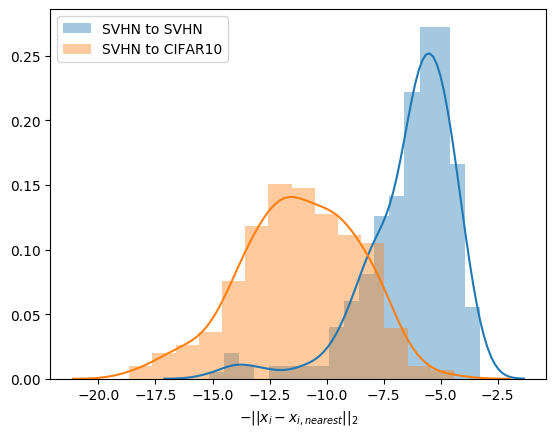

In [39]:
fig, ax = plt.subplots(1, 1)
seaborn.distplot(-nnd_train_svhn, ax=ax, label='SVHN to SVHN')
seaborn.distplot(-nnd_test1_svhn, ax=ax, label='SVHN to CIFAR10')
ax.set_xlabel('$-||x_i - x_{i, nearest}||_2$')
ax.legend()
fig.savefig(output_dir + '/DataDistance_SVHN-CIFAR10' + plot_ext, bbox_inches='tight')

In [25]:
n_samples = 200
train = cifar10_train.examples[:n_samples].reshape(n_samples, -1)
test1 = svhn_train.examples[:n_samples].reshape(n_samples, -1)
nnd_train_fashion = nearest_neighbour_distance(train, train, ignore_diag=True)
nnd_test1_fashion = nearest_neighbour_distance(test1, train, ignore_diag=False)

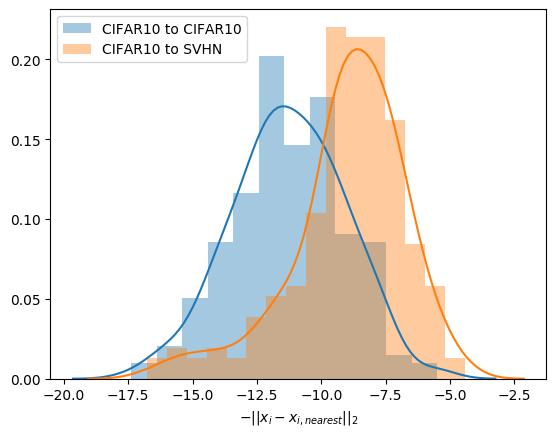

In [26]:
fig, ax = plt.subplots(1, 1)
seaborn.distplot(-nnd_train_fashion, ax=ax, label='CIFAR10 to CIFAR10')
seaborn.distplot(-nnd_test1_fashion, ax=ax, label='CIFAR10 to SVHN')
ax.set_xlabel('$-||x_i - x_{i, nearest}||_2$')
ax.legend()
fig.savefig(output_dir + '/DataDistance_CIFAR10-SVHN' + plot_ext, bbox_inches='tight')

## Load models

In [40]:
def get_data(train_data):
    if train_data == ['SVHNBinarized', 'SVHNContinuous']:
        x_train = svhn_train.examples.reshape(-1, 784)
        x_test1 = svhn_test1.examples.reshape(-1, 784)
        x_test2 = cifar10_test1.examples.reshape(-1, 784)
        y_train = svhn_train.labels.argmax(axis=1)
        y_test1 = svhn_test1.labels.argmax(axis=1)
        y_test2 = cifar10_test1.labels.argmax(axis=1)
    elif train_data == ['CIFAR10Binarized', 'CIFAR10Continuous']:
        x_train = cifar10_train.examples.reshape(-1, 784)
        x_test1 = cifar10_test1.examples.reshape(-1, 784)
        x_test2 = svhn_test1.examples.reshape(-1, 784)
        y_train = cifar10_train.labels.argmax(axis=1)
        y_test1 = cifar10_test1.labels.argmax(axis=1)
        y_test2 = svhn_test1.labels.argmax(axis=1)
    return x_train, x_test1, x_test2, y_train, y_test1, y_test2

In [41]:
def load_models(run_ids, device=torch.device('cpu')):
    models = dict()
    for model_abbr, run_id in run_ids.items():
        run_id = str(run_id)

        model = vari.models.HierarchicalVariationalAutoencoder
        # Load the saved kwargs
        kwargs = torch.load(
            os.path.join(experiments_dir, run_id, 'model_kwargs.pkl'),
            map_location=device,
        )
        model = model(**kwargs).to(device)

        try:
            model.load_state_dict(torch.load(
                os.path.join(experiments_dir, run_id, 'model_state_dict.pkl'),
                map_location=device
            ))
            models[model_abbr] = model
            print(f'Loaded ID {run_id} {model_abbr.upper()} on {device}')
        except Exception as exc:
            print(f'Failed loading {model_abbr.upper()} ID {run_id}')
            print(exc)
    return models

In [42]:
print('svhn')
models_svhn = load_models(run_ids_svhn, device=device)
print('cifar10')
models_cifar10 = load_models(run_ids_cifar10, device=device)

svhn
Loaded ID 7854 [64] on cuda:0
Failed loading [64,32] ID 7856
[Errno 2] No such file or directory: '/nas/experiments/sacred/models/7856/model_state_dict.pkl'
cifar10
Loaded ID 7848 [64,32,16] on cuda:0


## Visualize latent space

In [20]:
constant_cmap = get_constant_colormap((0.2, 0.2, 0.2))

def plot_vectors_and_mesh(vectors, mesh=None, fig=None, ax=None, figsize=(20, 20), color='C0', alpha=0.4, label='train', label_ids=None):
    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(1, 1, 1)
    
    if mesh is not None:
        ax.plot(mesh[:,0], mesh[:,1], c='black', alpha=.2, linewidth=.5)
        ax.scatter(mesh[:,0], mesh[:,1], c=[(.8, .8, .8, .8)], alpha=.5, s=5.)
    if label_ids is not None:
        for i in np.unique(label_ids):
            ax.scatter(vectors[label_ids==i, 0], vectors[label_ids==i, 1], c=f'C{i}', alpha=alpha, label=f"{label}:class{i}")
    else:
        ax.scatter(vectors[:,0], vectors[:,1], c=color, alpha=alpha, label=label)
    #ax1.scatter(vae_qz_mu_x2[:,0], vae_qz_mu_x2[:,1], c=[test1_0], alpha=0.4, label="test1")
    # ax1.axis('off')
    ax.legend()
    return fig, ax

### svhn

7085 z1
7087 z1
7087 z2
7117 z1
7097 z1
7097 z2


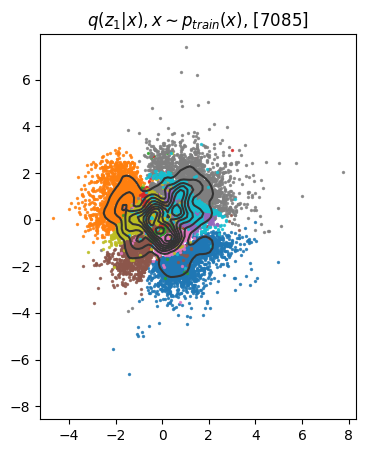

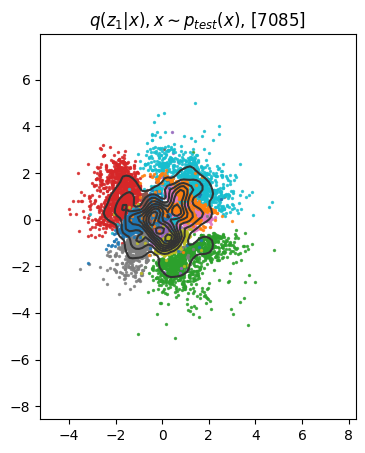

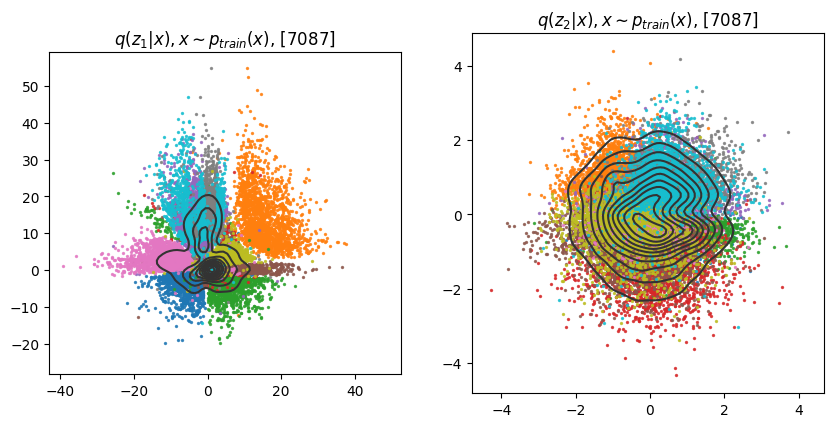

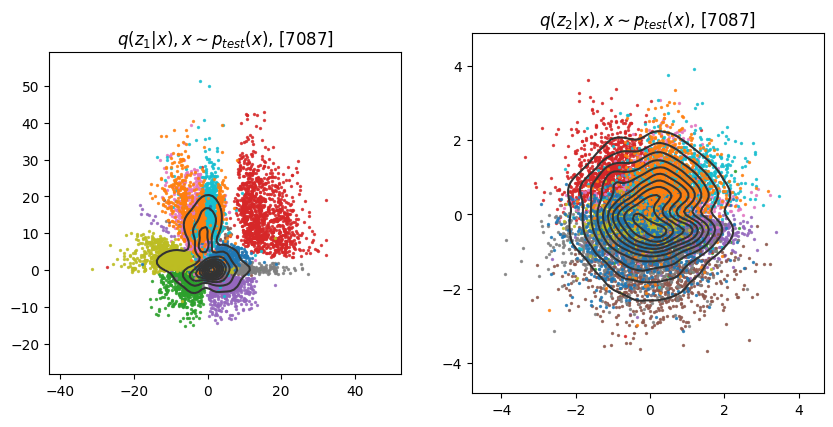

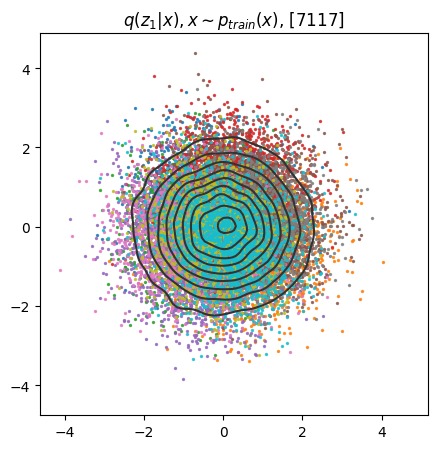

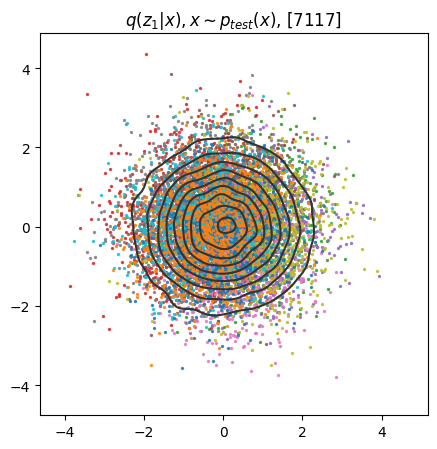

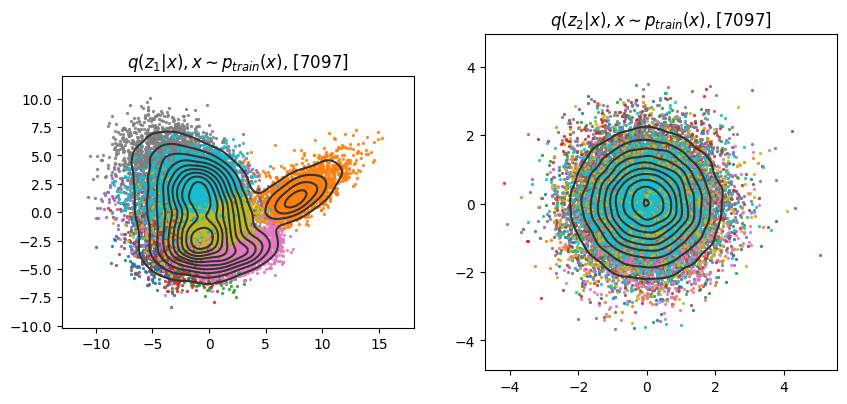

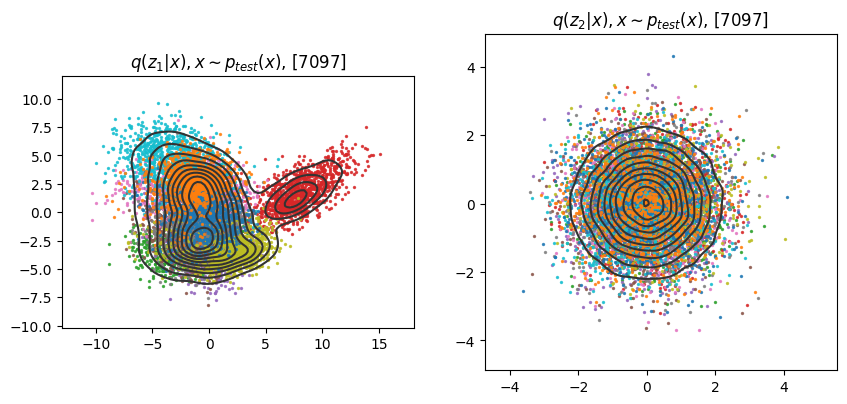

In [227]:
x_train, x_test1, x_test2, y_train, y_test1, y_test2 = get_data('SVHNBinarized')

n_scats = 2000

for abbr, model in models_svhn.items():
    torch.manual_seed(1)
    with torch.no_grad():
        latents_train = model.encode(torch.FloatTensor(x_train))
        latents_test1 = model.encode(torch.FloatTensor(x_test1))
        
    n_cols = len(latents_train.keys())
    fig, axes = plt.subplots(1, n_cols, figsize=(5 * n_cols, 5))
    if n_cols == 1:
        axes = [axes]
    for i, name in enumerate(latents_train.keys(), start=1):
        print(abbr, name)
        qz_train = latents_train[name][0].squeeze().numpy()
        qz_mu_train = latents_train[name][1].mean.squeeze().numpy()
        
        # PCA if more than 2D
        if qz_train.shape[-1] > 2:
            pca = PCA(n_components=2, random_state=0)
            qz_train = pca.fit_transform(qz_train)
            pca = PCA(n_components=2, random_state=0)
            qz_mu_train = pca.fit_transform(qz_mu_train)

        axes[i - 1].set_title(f'$q(z_{i}|x), x\sim p_{{train}}(x)$, [{abbr.upper()}]')
        for c in set(y_train):
            axes[i - 1].scatter(qz_train[y_train==c, 0][:n_scats],
                                qz_train[y_train==c, 1][:n_scats],
                                marker='o', s=2, alpha=0.8, color=f'C{c}', label=f'$z_{i}$ class {c}')
        seaborn.kdeplot(qz_train[:, 0],
                        qz_train[:, 1],
                        shade=False, cmap=constant_cmap, label=f'$q(z_{i}|x)$', ax=axes[i - 1])
        axes[i - 1].set_aspect('equal')
        #axes[i - 1].legend()
    fig.savefig(output_dir + f'/Moons_LatentSpace_train_ID{abbr}' + plot_ext, bbox_inches='tight')

    fig, axes = plt.subplots(1, n_cols, figsize=(5 * n_cols, 5))
    if n_cols == 1:
        axes = [axes]
    for i, name in enumerate(latents_train.keys(), start=1):
        qz_train = latents_train[name][0].squeeze().numpy()
        qz_mu_train = latents_train[name][1].mean.squeeze().numpy()
        qz_test1 = latents_test1[name][0].squeeze().numpy()
        qz_mu_test1 = latents_test1[name][1].mean.squeeze().numpy()
        
        # PCA if more than 2D
        if qz_train.shape[-1] > 2:
            pca = PCA(n_components=2, random_state=0)
            qz_train = pca.fit_transform(qz_train)
            pca = PCA(n_components=2, random_state=0)
            qz_mu_train = pca.fit_transform(qz_mu_train)
            pca = PCA(n_components=2, random_state=0)
            qz_test1 = pca.fit_transform(qz_test1)
            pca = PCA(n_components=2, random_state=0)
            qz_mu_test1 = pca.fit_transform(qz_mu_test1)

        axes[i - 1].set_title(f'$q(z_{i}|x), x\sim p_{{test}}(x)$, [{abbr.upper()}]')
        for c in set(y_test1):
            axes[i - 1].scatter(qz_test1[y_test1==c, 0],
                                qz_test1[y_test1==c, 1],
                                marker='o', s=2, alpha=0.8, color=f'C{c+2}', label=f'$z_{i}$ class {c}')
        seaborn.kdeplot(qz_train[:, 0],
                        qz_train[:, 1],
                        shade=False, cmap=constant_cmap, label=f'$q(z_{i}|x)$', ax=axes[i - 1])
        axes[i - 1].set_aspect('equal')
        #axes[i - 1].legend()
    fig.savefig(output_dir + f'/Moons_LatentSpace_test_ID{abbr}' + plot_ext, bbox_inches='tight')



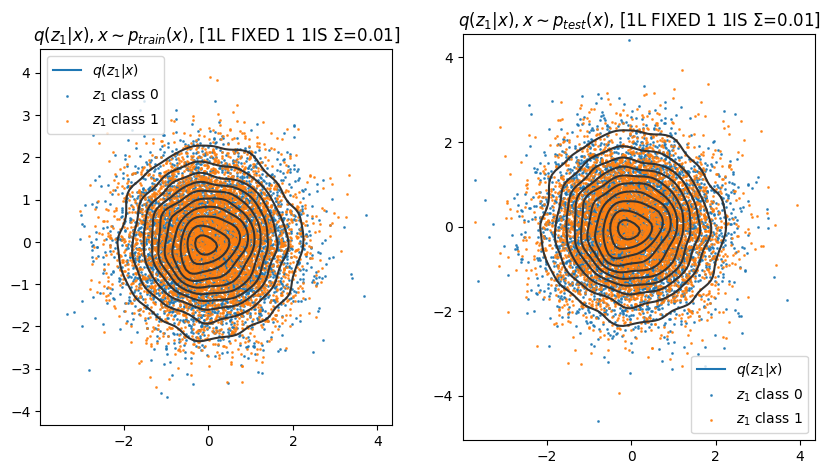

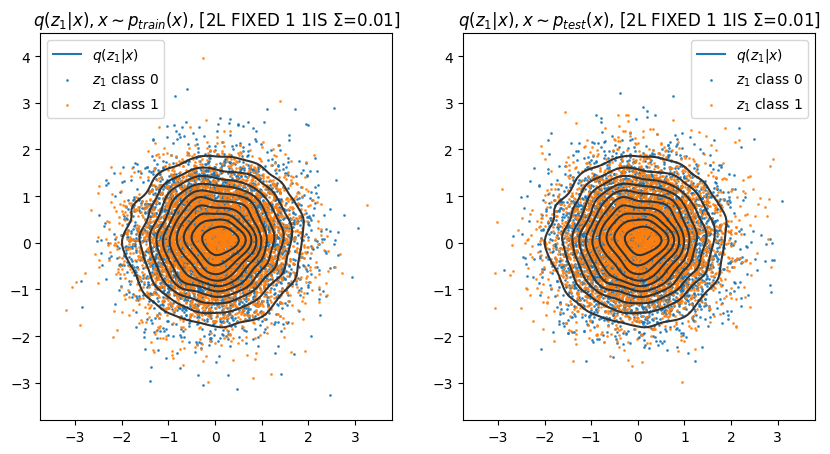

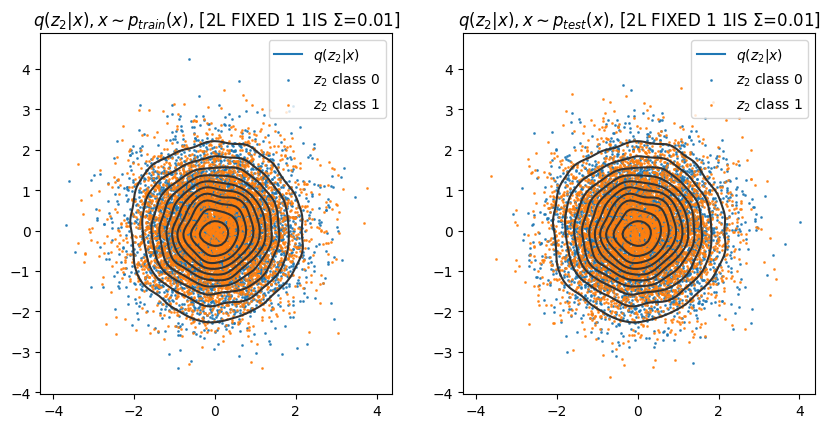

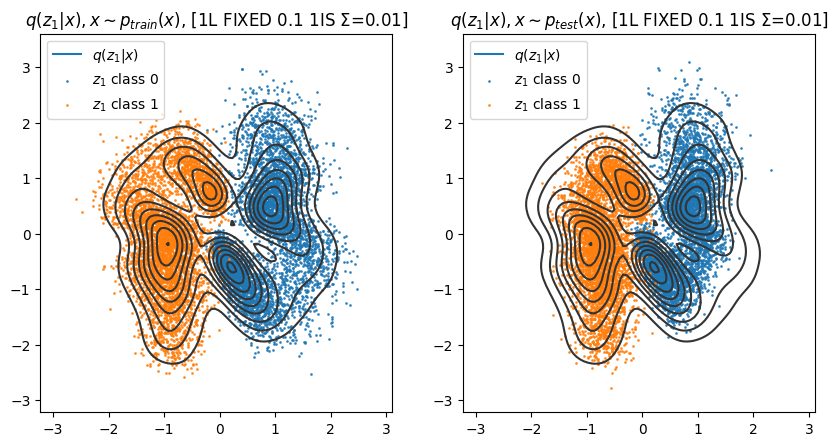

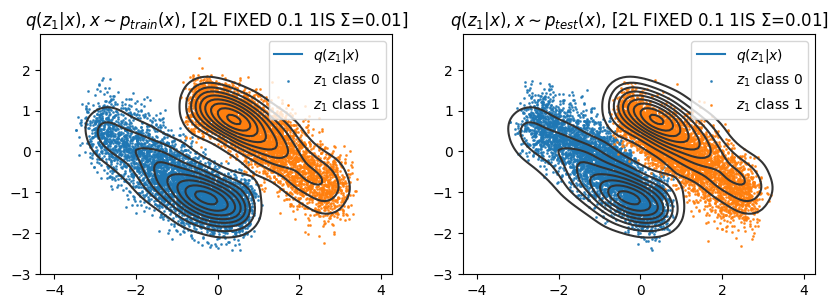

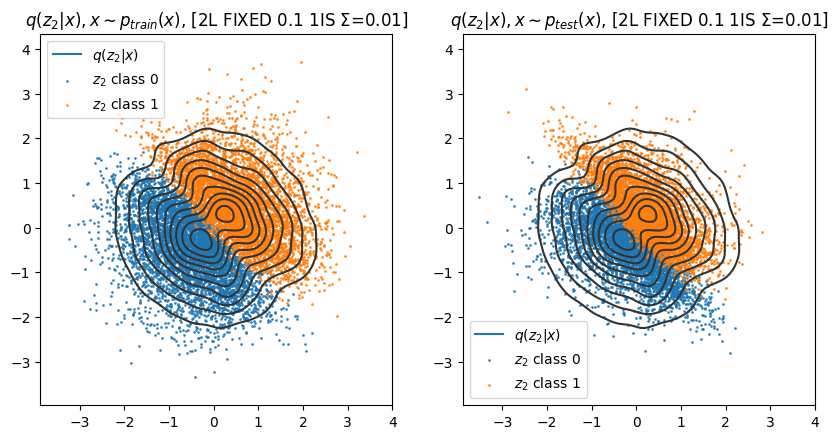

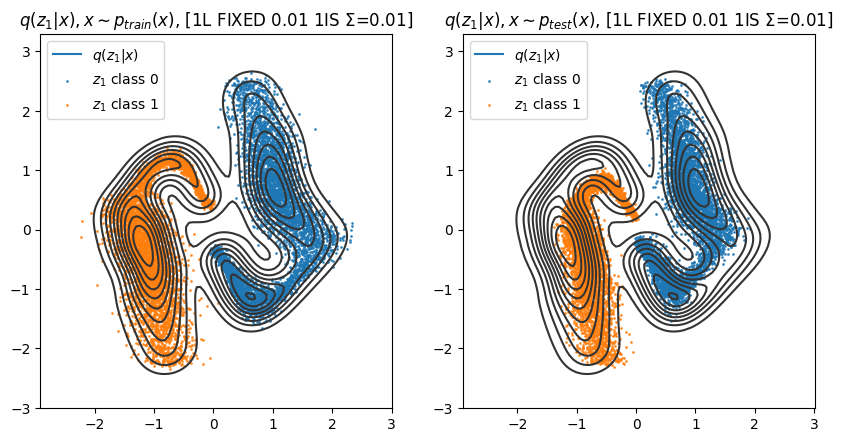

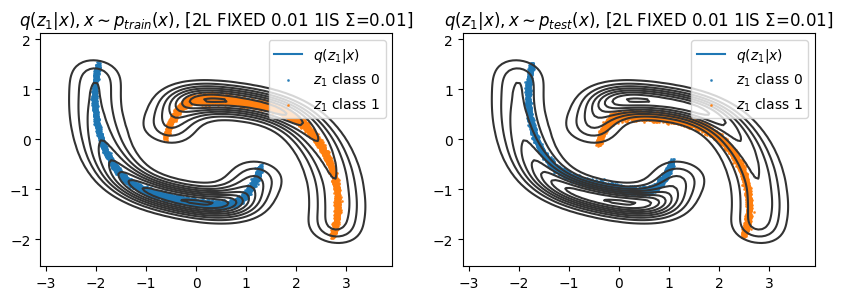

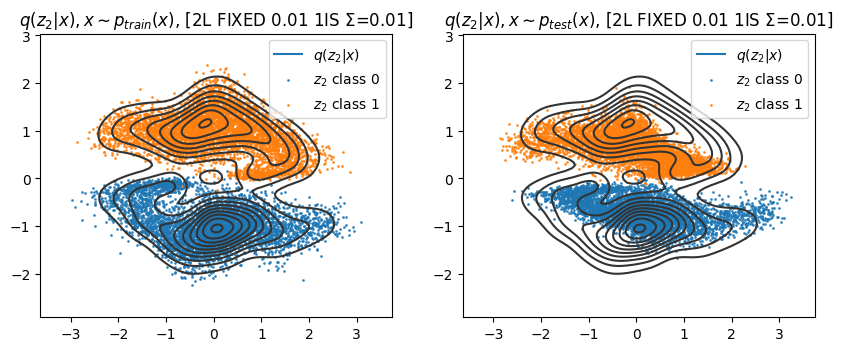

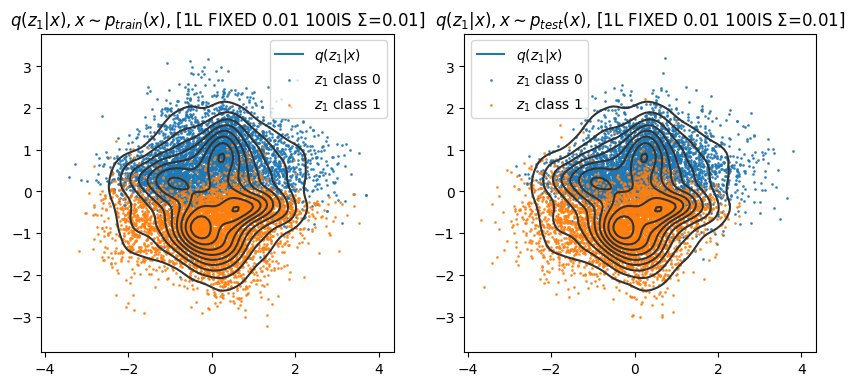

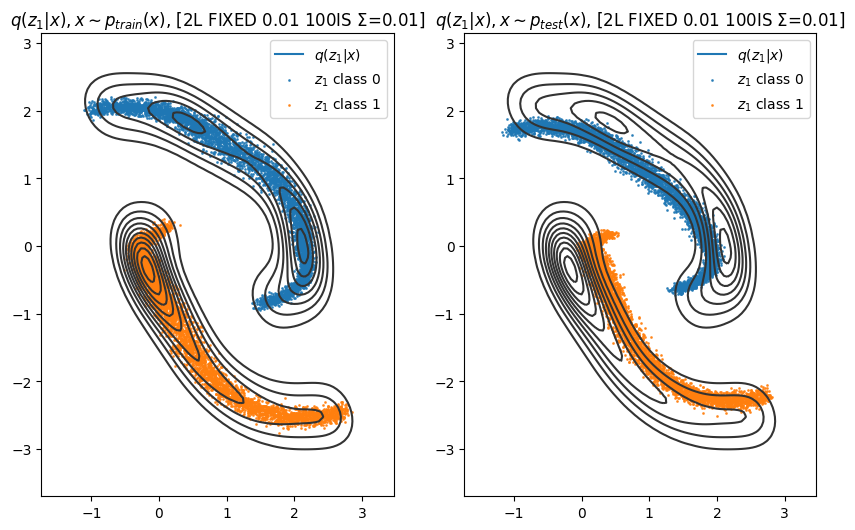

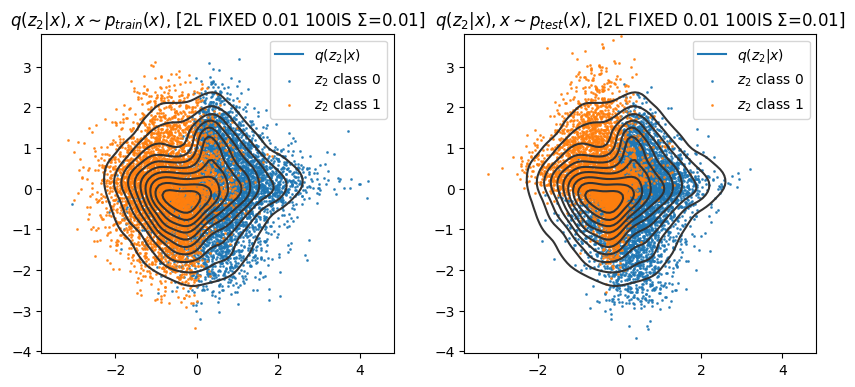

In [111]:
x_train, x_test1, x_test2, y_train, y_test1, y_test2 = get_data('SVHNBinarized')
for abbr, model in models.items():
    with torch.no_grad():
        latents_train = model.encode(torch.FloatTensor(x_train))
        latents_test1 = model.encode(torch.FloatTensor(x_test1))

    for i_layer, name in enumerate(latents_train.keys(), start=1):
        qz_train = latents_train[name][0].squeeze()
        qz_mu_train = latents_train[name][1].mean.squeeze()

        qz_test1 = latents_test1[name][0].squeeze()
        qz_mu_test1 = latents_test1[name][1].mean.squeeze()

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
        
        ax1.set_title(f'$q(z_{i_layer}|x), x\sim p_{{train}}(x)$, [{abbr.upper()}]')
        for c in set(y_train):
            ax1.scatter(qz_train[y_train==c, 0].numpy(),
                        qz_train[y_train==c, 1].numpy(),
                        marker='o', s=1, alpha=0.8, color=f'C{c}', label=f'$z_{i_layer}$ class {c}')
        seaborn.kdeplot(qz_train[:, 0].numpy(),
                        qz_train[:, 1].numpy(),
                        shade=False, cmap=constant_cmap, label=f'$q(z_{i_layer}|x)$', ax=ax1)
        ax1.set_aspect('equal')
        ax1.legend()
        
        ax2.set_title(f'$q(z_{i_layer}|x), x\sim p_{{test}}(x)$, [{abbr.upper()}]')
        for c in set(y_test1):
            ax2.scatter(qz_test1[y_test1==c, 0].numpy(),
                        qz_test1[y_test1==c, 1].numpy(),
                        marker='o', s=1, alpha=0.8, color=f'C{c}', label=f'$z_{i_layer}$ class {c}')
        seaborn.kdeplot(qz_train[:, 0].numpy(),
                        qz_train[:, 1].numpy(),
                        shade=False, cmap=constant_cmap, label=f'$q(z_{i_layer}|x)$', ax=ax2)
        ax2.set_aspect('equal')
        ax2.legend()

### cifar10

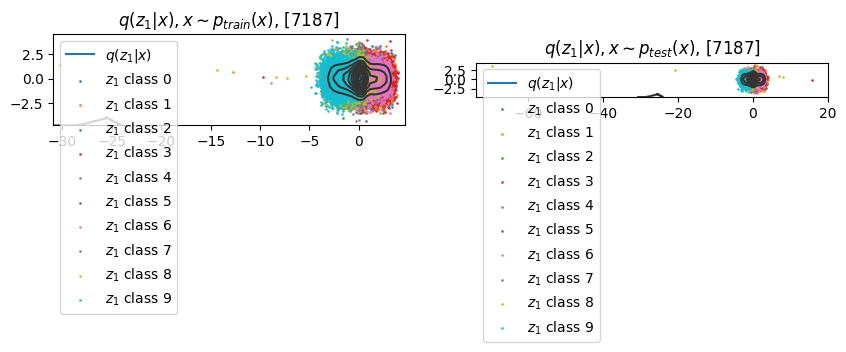

In [21]:
x_train, x_test1, x_test2, y_train, y_test1, y_test2 = get_data('CIFAR10Binarized')
for abbr, model in models_cifar10.items():
    with torch.no_grad():
        latents_train = model.encode(torch.FloatTensor(x_train))
        latents_test1 = model.encode(torch.FloatTensor(x_test1))

    for i_layer, name in enumerate(latents_train.keys(), start=1):
        qz_train = latents_train[name][0].squeeze()
        qz_mu_train = latents_train[name][1].mean.squeeze()

        qz_test1 = latents_test1[name][0].squeeze()
        qz_mu_test1 = latents_test1[name][1].mean.squeeze()

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
        
        ax1.set_title(f'$q(z_{i_layer}|x), x\sim p_{{train}}(x)$, [{abbr.upper()}]')
        for c in set(y_train):
            ax1.scatter(qz_train[y_train==c, 0].numpy(),
                        qz_train[y_train==c, 1].numpy(),
                        marker='o', s=1, alpha=0.8, color=f'C{c}', label=f'$z_{i_layer}$ class {c}')
        seaborn.kdeplot(qz_train[:, 0].numpy(),
                        qz_train[:, 1].numpy(),
                        shade=False, cmap=constant_cmap, label=f'$q(z_{i_layer}|x)$', ax=ax1)
        ax1.set_aspect('equal')
        ax1.legend()
        
        ax2.set_title(f'$q(z_{i_layer}|x), x\sim p_{{test}}(x)$, [{abbr.upper()}]')
        for c in set(y_test1):
            ax2.scatter(qz_test1[y_test1==c, 0].numpy(),
                        qz_test1[y_test1==c, 1].numpy(),
                        marker='o', s=1, alpha=0.8, color=f'C{c}', label=f'$z_{i_layer}$ class {c}')
        seaborn.kdeplot(qz_train[:, 0].numpy(),
                        qz_train[:, 1].numpy(),
                        shade=False, cmap=constant_cmap, label=f'$q(z_{i_layer}|x)$', ax=ax2)
        ax2.set_aspect('equal')
        ax2.legend()

## Visualize reconstruction and samples
### SVHN models

In [43]:
def get_copy_latents(n_layers, free_latents):
    return dict((f'z{i+1}', True) if i >= free_latents else (f'z{i+1}', False) for i in range(n_layers))

In [46]:
def plot_sample_reconstruct(model, data, free_latents=False):
    x_in = torch.FloatTensor(data)
    
    with torch.no_grad():
        px_samples = model.generate(n_samples)

    fig, axes = plt.subplots(1, 3 + free_latents * (model.n_layers - 1), figsize=(10, 15))
    plot_image_matrix([x.view(*svhn_test1[0][0].shape) for x in x_in], axes[0])
    plot_image_matrix([x.view(*svhn_test1[0][0].shape) for x in px_samples.mean.cpu()], axes[-1])
    with torch.no_grad():
        if free_latents:
            for free_latents in range(model.n_layers):
                copy_latents = get_copy_latents(model.n_layers, free_latents)
                px_reconstructions = model(x_in.reshape(x_in.shape[0], *model.in_shape).to(device),
                                                     copy_latents=copy_latents)
                plot_image_matrix([x.reshape(*svhn_test1[0][0].shape) for x in px_reconstructions.mean.cpu()],
                                  axes[free_latents+1])
                axes[free_latents+1].set_title(f'Rec. ({free_latents} free)')
        else:
            px_reconstructions = model(x_in.view(x_in.shape[0], *model.in_shape).to(device))
            plot_image_matrix([x.view(*svhn_test1[0][0].shape) for x in px_reconstructions.mean.cpu()], axes[1])
            axes[1].set_title('Reconstructions')

    axes[0].set_title('Originals')
    axes[-1].set_title('Samples')
    return fig, axes

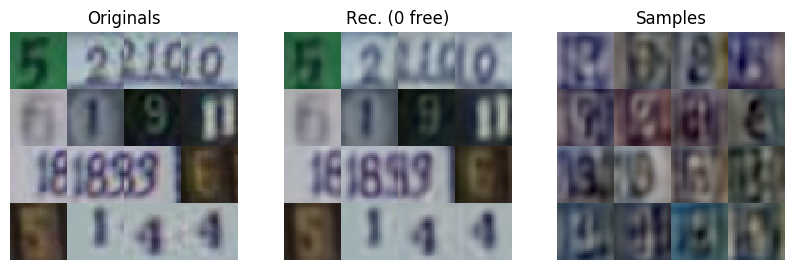

In [47]:
models = models_svhn
n_samples = 4*4

for abbr, model in models.items():
    fig, axes = plot_sample_reconstruct(model, svhn_test1[:n_samples][0], free_latents=True)
    fig_name = f'{abbr}'
    fig.savefig(output_dir + f'/SVHN_SampleReconstruct_SVHN_ID{fig_name}' + plot_ext, bbox_inches='tight')

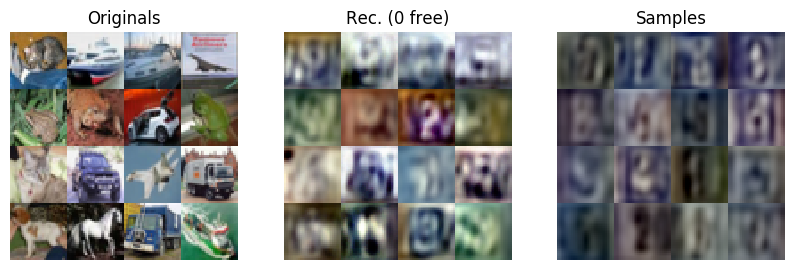

In [48]:
models = models_svhn
n_samples = 4*4

for abbr, model in models.items():
    fig, axes = plot_sample_reconstruct(model, cifar10_test1[:n_samples][0], free_latents=True)
    fig_name = f'{abbr}'
    fig.savefig(output_dir + f'/SVHN_SampleReconstruct_CIFAR10_ID{fig_name}' + plot_ext, bbox_inches='tight')

The more complex the dataset, the more abstract and diverse the set of features that the model needs to learn becomes.

Models that are trained on complex datasets and succesfully learn such a diverse set of abstract features may show surprisingly good performance on reconstructing simpler datasets that share some fundamental features.

**Observation**
The smaller models have a harder time reconstructing out of domain data. Multilayered models perform better at this. However, when not copying all latents in the hierarchy, the multilayered models regain their superiority over single-layered models and nicely collapse the out-of-distribution inputs into the mode of the training set.

**Hypothesis**
If we use convolutional models this trend will be even more pronounced since features are learned invariant to position withing the image.

### CIFAR10 models

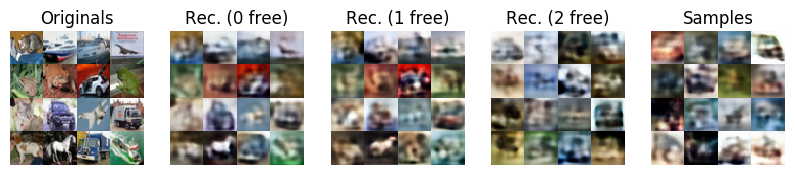

In [49]:
models = models_cifar10
n_samples = 4*4

for abbr, model in models.items():
    fig, axes = plot_sample_reconstruct(model, cifar10_test1[:n_samples][0], free_latents=True)
    fig_name = f'{abbr}'
    fig.savefig(output_dir + f'/CIFAR10_SampleReconstruct_CIFAR10_ID{fig_name}' + plot_ext, bbox_inches='tight')

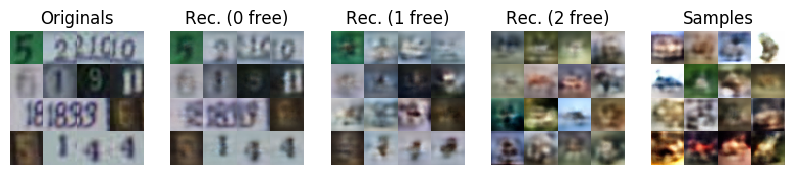

In [50]:
models = models_cifar10
n_samples = 4*4

for abbr, model in models.items():
    fig, axes = plot_sample_reconstruct(model, svhn_test1[:n_samples][0], free_latents=True)
    fig_name = f'{abbr}'
    fig.savefig(output_dir + f'/CIFAR10_SampleReconstruct_SVHN_ID{fig_name}' + plot_ext, bbox_inches='tight')

## OOD detection based on ELBO

In [51]:
def log_transform(x):
     return np.sign(x) * np.log(np.abs(x))

def log_transform_2(x, C=0):
    return np.sign(x) * np.log(1 + np.abs(x) / 10 ** C)

In [52]:
def plot_ood(model, loaders, free_latents=0, importance_samples=1, log_prob_transform=None):
    copy_latents = get_copy_latents(model.n_layers, free_latents)

    if log_prob_transform is None:
        log_prob_transform = lambda x: x
    
    n_cols = int(model.n_layers > 1) + 3
    fig, axes = plt.subplots(1, n_cols, figsize=(5 * n_cols, 5))
    
    with torch.no_grad():
        for i_loader, (name, loader) in enumerate(loaders.items()):
            torch.manual_seed(0)

            elbo, likelihood, kl, kls = compute_dataset_elbo(model, loader, device=device,
                                                             copy_latents=copy_latents,
                                                             reduce_importance_samples=False,
                                                             importance_samples=importance_samples)
            
            elbo = torch.mean(elbo.view(importance_samples, -1), axis=0).cpu()
            likelihood = torch.mean(likelihood.view(importance_samples, -1), axis=0).cpu()
            kl = torch.mean(kl.view(importance_samples, -1), axis=0).cpu()
            
            (elbo, likelihood, kl), _ = remove_outliers(elbo, likelihood, kl)
            
            seaborn.distplot(log_prob_transform(elbo), kde_kws={}, ax=axes[0], label=name)
            seaborn.distplot(log_prob_transform(likelihood), kde_kws={}, ax=axes[1], label=name)
            seaborn.distplot(log_prob_transform(kl), kde_kws={}, ax=axes[2], label=name)
            
            if model.n_layers > 1:
                for i_latent, (latent_name, value) in enumerate(reversed(kls.items())):
                    value = torch.mean(value.view(importance_samples, -1), axis=0).cpu()
                    value, _ = remove_outliers(value)
                    seaborn.distplot(value, kde_kws={}, ax=axes[3], label=f'{latent_name} {name}',
                                     color=f'C{i_latent * len(loaders) + i_loader}')
    
    labels = (r'$\log p(x)$', r'$\log p(x|z)$', r'$\frac{\log q(z|x)}{\log p(z)}$',
                                                r'$\frac{\log q(z|x)}{\log p(z)}$')
    for i, ax in enumerate(axes):
        ax.legend()
        ax.set_xlabel(labels[i])

    return fig, axes

In [54]:
svhn_train = vari.datasets.SVHNContinuous(split='train', preprocess='dynamic',
                                          exclude_labels=[], root=data_root)
svhn_test1 = vari.datasets.SVHNContinuous(split='test', preprocess='dynamic',
                                          exclude_labels=[], root=data_root)
cifar10_train = vari.datasets.CIFAR10Continuous(split='train', preprocess='dynamic',
                                                exclude_labels=[], root=data_root)
cifar10_test1 = vari.datasets.CIFAR10Continuous(split='test', preprocess='dynamic',
                                                exclude_labels=[], root=data_root)

Using downloaded and verified file: /home/jdh/repos/vari/torch_data/train_32x32.mat
Using downloaded and verified file: /home/jdh/repos/vari/torch_data/test_32x32.mat
Files already downloaded and verified
Files already downloaded and verified


In [55]:
loader_cifar10_test1 = DataLoader(cifar10_test1, batch_size=256, pin_memory=True)
loader_svhn_test1 = DataLoader(svhn_test1, batch_size=256, pin_memory=True)

In [56]:
seaborn.set_palette('tab20')

### svhn

0 [64]


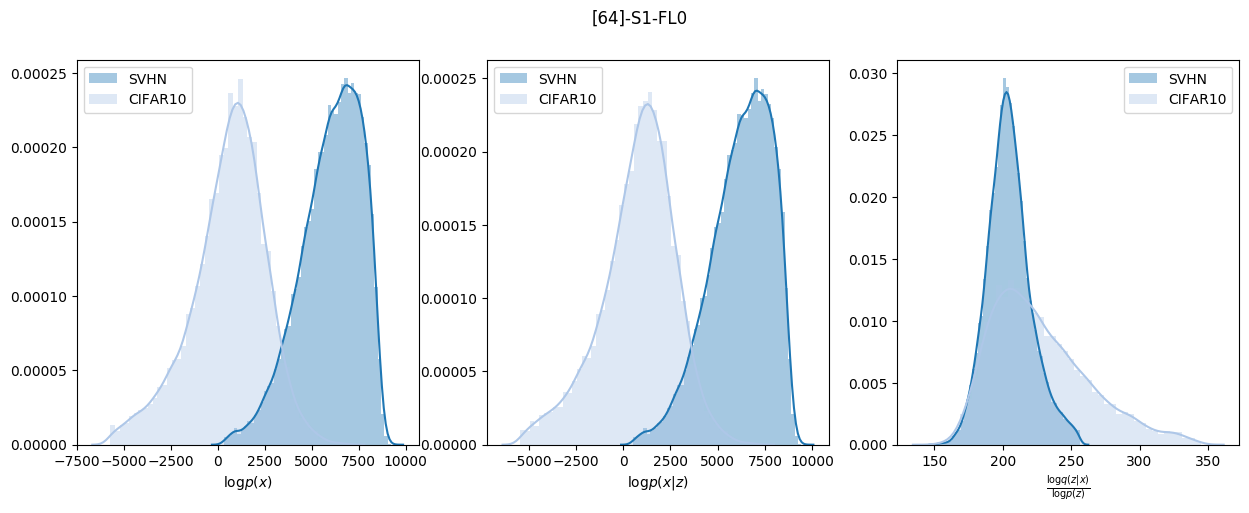

In [57]:
models = models_svhn
loaders_svhn = dict(SVHN=loader_svhn_test1,
                     CIFAR10=loader_cifar10_test1)
importance_samples = 1

for abbr, model in models.items():
    for free_latents in range(0, model.n_layers):
        print(free_latents, abbr)
        fig_name = f'{abbr}-S{importance_samples}-FL{free_latents}'
        
        fig, axes = plot_ood(model, loaders_svhn, free_latents=free_latents, importance_samples=importance_samples,
                            )#log_prob_transform=log_transform)
        
        fig.suptitle(fig_name)
        fig.savefig(output_dir + f'/SVHN_OOD_ID{fig_name}' + plot_ext, bbox_inches='tight')

0 [64]


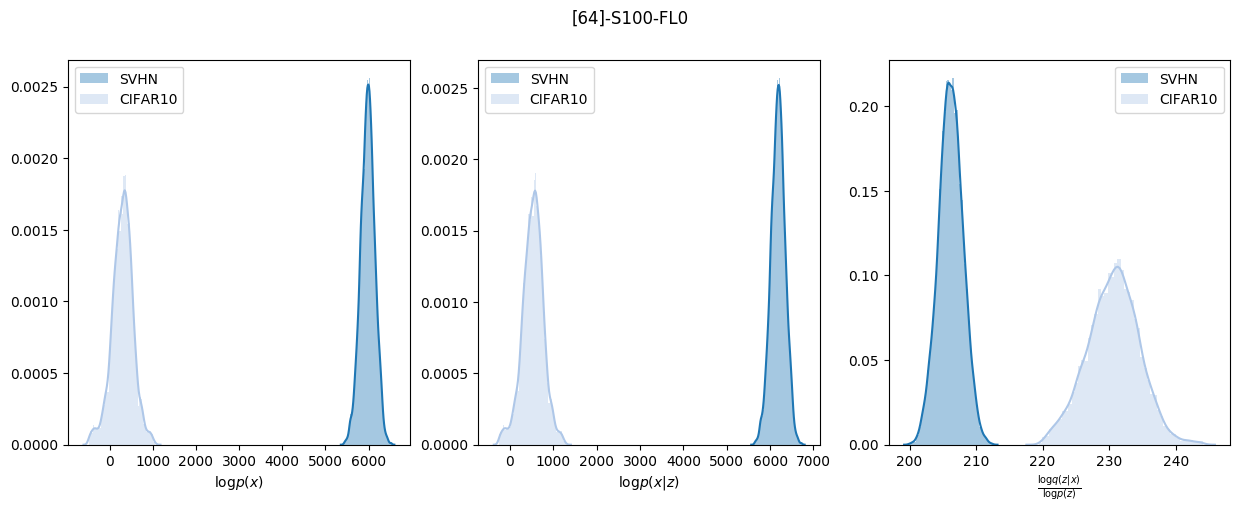

In [58]:
models = models_svhn
loaders_svhn = dict(SVHN=loader_svhn_test1,
                     CIFAR10=loader_cifar10_test1)
importance_samples = 100

for abbr, model in models.items():
    for free_latents in range(0, model.n_layers):
        print(free_latents, abbr)
        fig_name = f'{abbr}-S{importance_samples}-FL{free_latents}'
        
        fig, axes = plot_ood(model, loaders_svhn, free_latents=free_latents, importance_samples=importance_samples)
        
        fig.suptitle(fig_name)
        fig.savefig(output_dir + f'/SVHN_OOD_ID{fig_name}' + plot_ext, bbox_inches='tight')

### cifar10

0 [64,32,16]
1 [64,32,16]
2 [64,32,16]


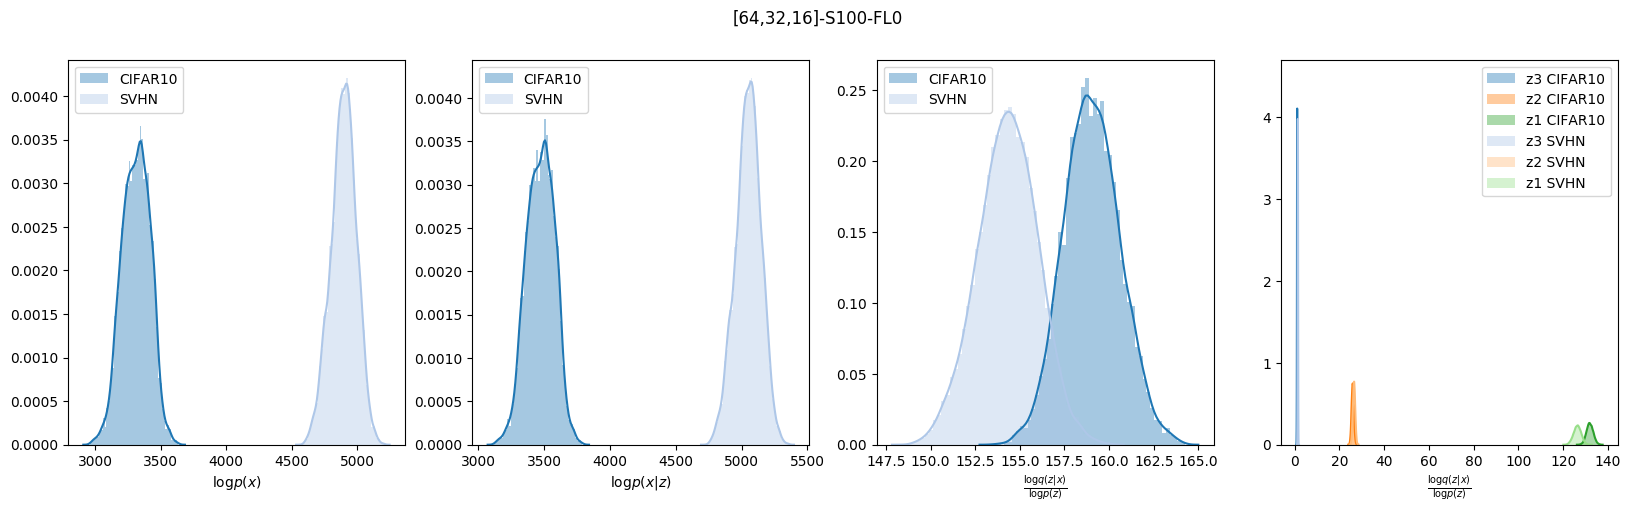

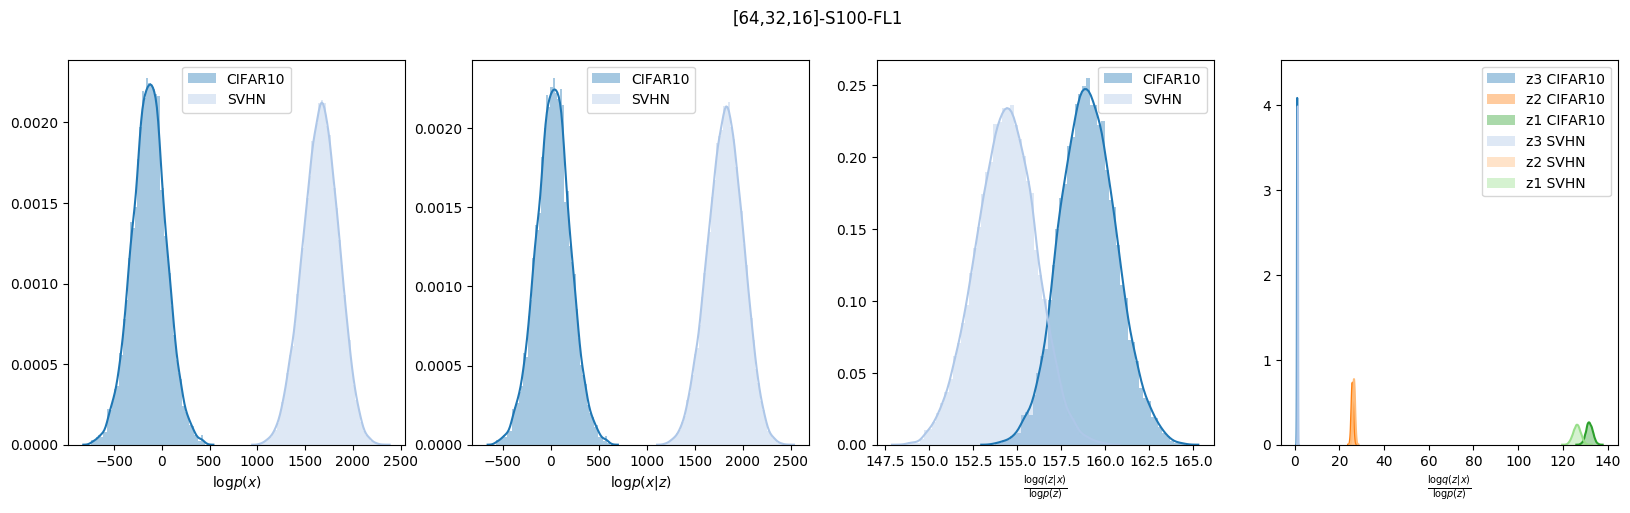

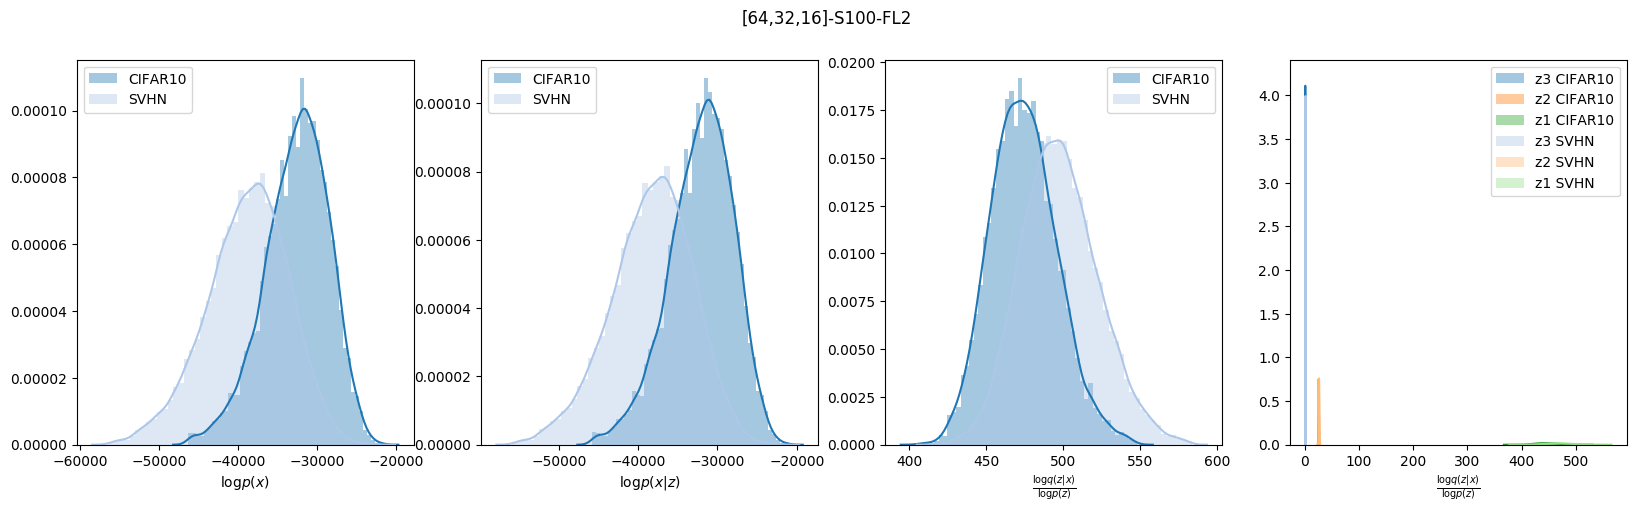

In [59]:
models = models_cifar10
loaders_svhn = dict(CIFAR10=loader_cifar10_test1,
                    SVHN=loader_svhn_test1,)
importance_samples = 100

for abbr, model in models.items():
    for free_latents in range(0, model.n_layers):
        print(free_latents, abbr)
        fig_name = f'{abbr}-S{importance_samples}-FL{free_latents}'
        
        fig, axes = plot_ood(model, loaders_svhn, free_latents=free_latents, importance_samples=importance_samples)
        
        fig.suptitle(fig_name)
        fig.savefig(output_dir + f'/CIFAR10_OOD_ID{fig_name}' + plot_ext, bbox_inches='tight')

0 [64,32,16]
1 [64,32,16]
2 [64,32,16]


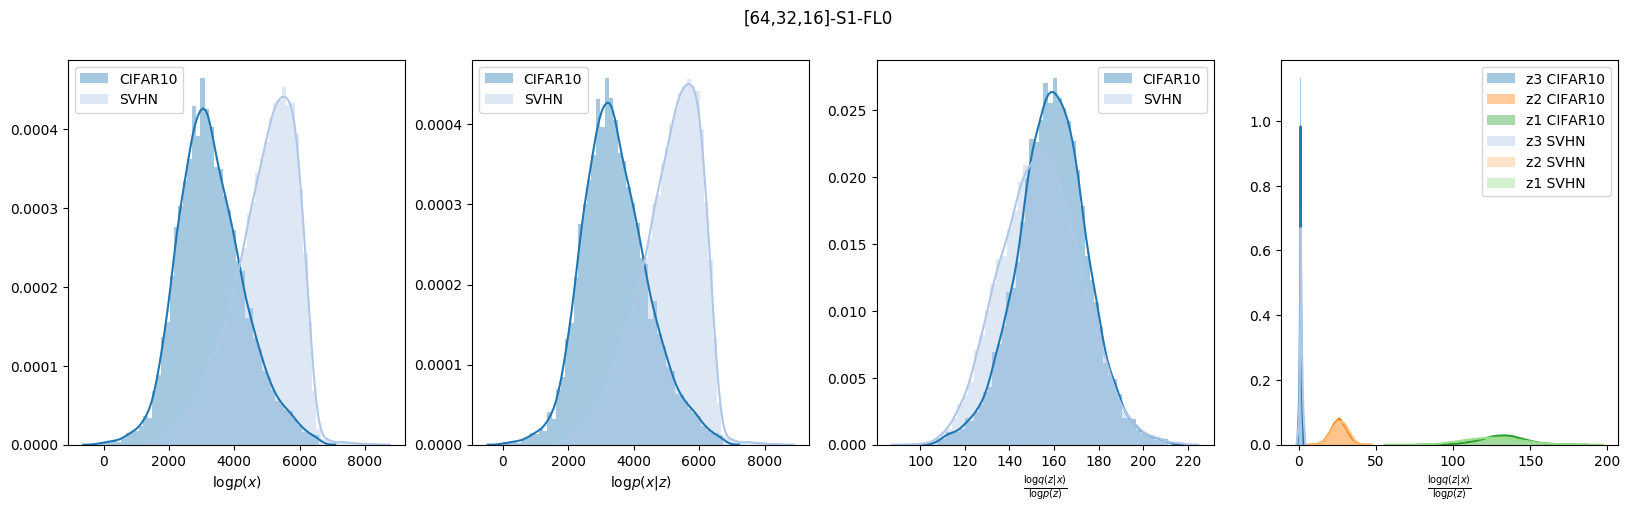

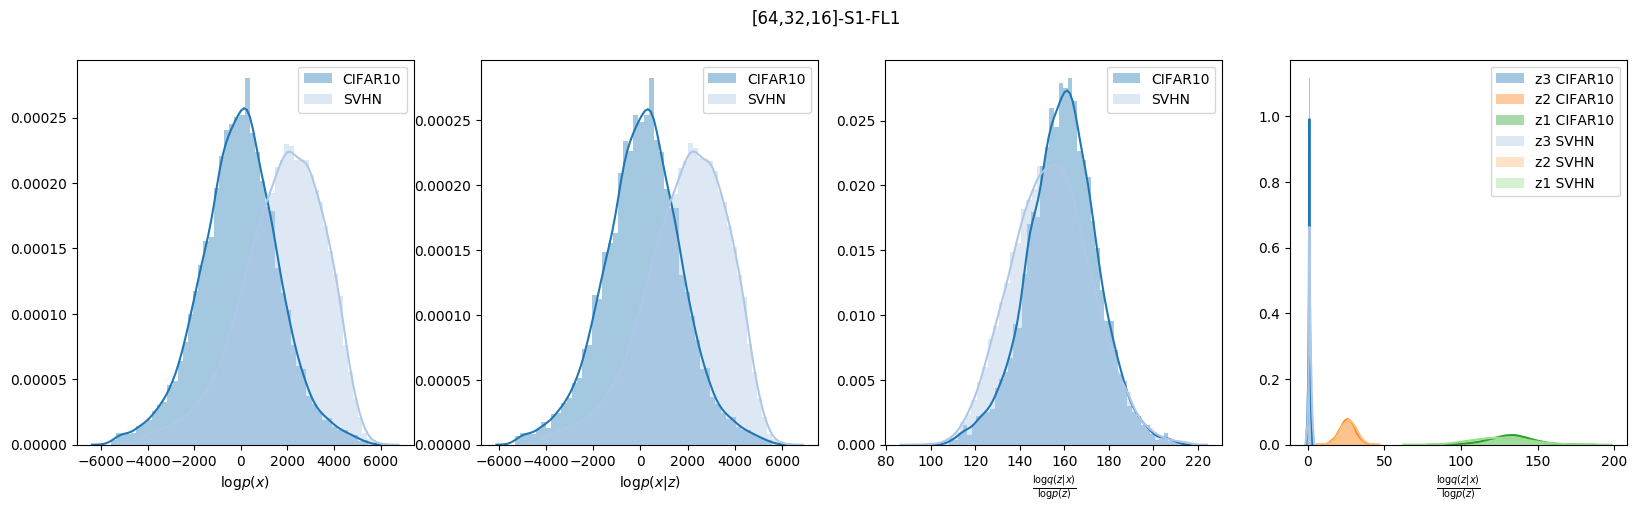

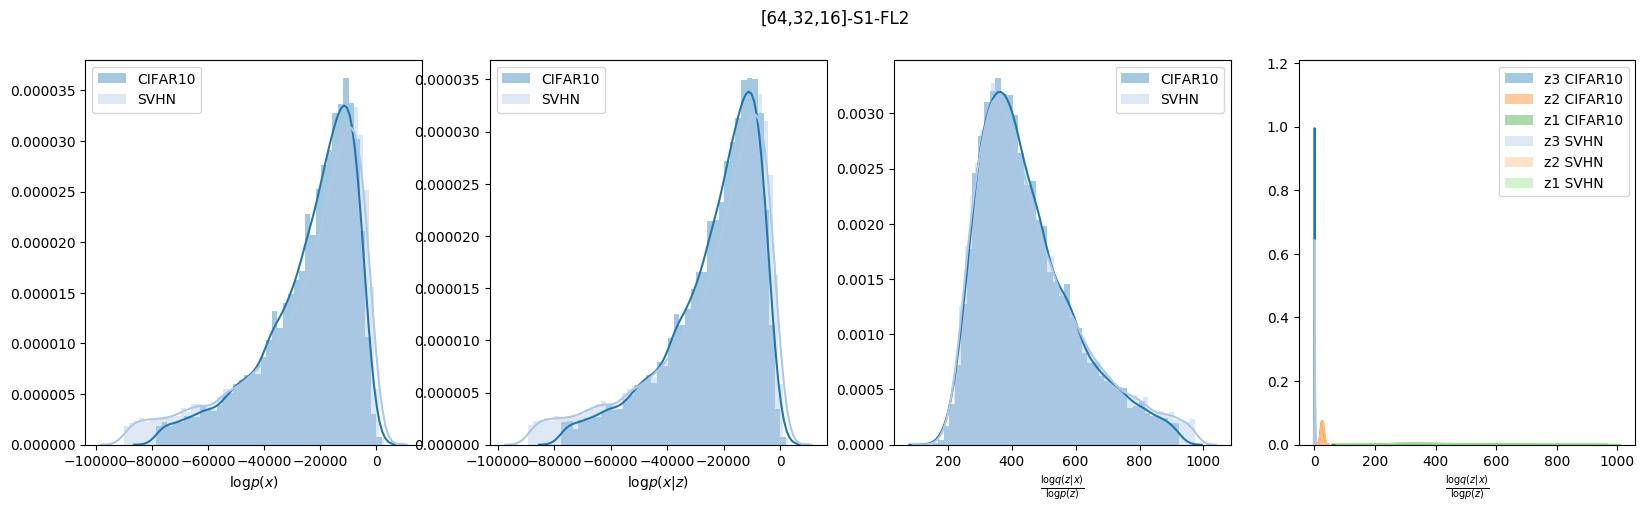

In [60]:
models = models_cifar10
loaders_svhn = dict(CIFAR10=loader_cifar10_test1,
                     SVHN=loader_svhn_test1,)
importance_samples = 1

for abbr, model in models.items():
    for free_latents in range(0, model.n_layers):
        print(free_latents, abbr)
        fig_name = f'{abbr}-S{importance_samples}-FL{free_latents}'
        
        fig, axes = plot_ood(model, loaders_svhn, free_latents=free_latents, importance_samples=importance_samples)
        
        fig.suptitle(fig_name)
        fig.savefig(output_dir + f'/CIFAR10_OOD_ID{fig_name}' + plot_ext, bbox_inches='tight')

## Animate generation during training

In [104]:
import matplotlib.pyplot as plt
import natsort

from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [112]:
from IPython import embed
def get_substring_digit(s):
    return int(''.join([ss for ss in s if ss.isdigit()]))

def get_training_samples(run_id):
    npys = dict()
    for f in os.listdir(os.path.join(experiments_dir, str(run_id))):
        if f.endswith('model_samples.npy'):
            epoch = get_substring_digit(f)
            npys[epoch] = np.load(os.path.join(experiments_dir, str(run_id), f))
    return npys

def get_training_latents(run_id):
    npys = dict()
    for f in os.listdir(os.path.join(experiments_dir, str(run_id))):
        if f.endswith('model_latents.pkl'):
            epoch = get_substring_digit(f)
            npys[epoch] = torch.load(os.path.join(experiments_dir, str(run_id), f))
    return npys

In [113]:
run_id = '6867'
samples = get_training_samples(run_id)
latents = get_training_latents(run_id)

ValueError: invalid literal for int() with base 10: ''

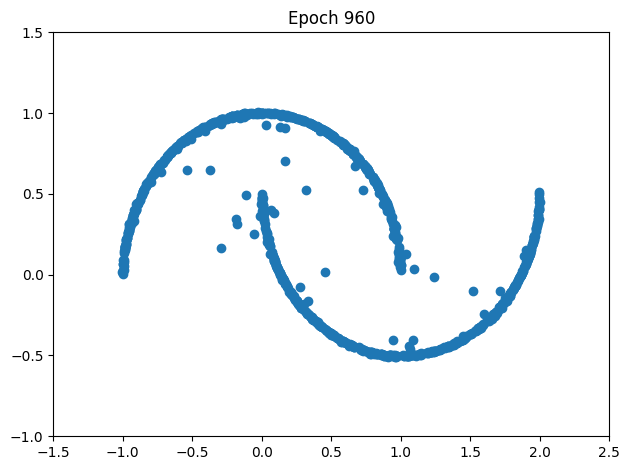

In [109]:
fig, ax = plt.subplots()
fig.set_tight_layout(True)
scat = ax.scatter([], [])

def init():
    return (scat, )

def update(i):
    scat.set_offsets(npys[i])
    ax.set_xlim([-1.5, 2.5])
    ax.set_ylim([-1, 1.5])
    ax.set_title(f'Epoch {i}')
    return (scat, )
    
    
epochs_sorted = natsort.natsorted(npys.keys())
anim = FuncAnimation(fig,
                     update,
                     frames=[*epochs_sorted[:1]*10, *epochs_sorted, *epochs_sorted[-1:]*10], 
                     init_func=init,
                     interval=150,
                     blit=True)

HTML(anim.to_html5_video())

In [679]:
anim.save(f'training_samples_{run_id}.mp4', codec='h264')